In [1]:
# Generates simulated data 
 
# Modified from Emilio Andreozzi "Phenomenological models of NaV1.5.
    # A side by side, procedural, hands-on comparison between
    # Hodgkin-Huxley and kinetic formalisms." 2019
# Emily Nguyen
 
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import optimize, stats

# change to affect runtime
h.dt = 0.025 

##################
# Activation Na 1.2 
##################e

# TODO consider making a class instead of func - Emily
def activationNa12(command, \
                  soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                  channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                  dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                  f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120, \
                  x_axis_min=-100, x_axis_max=40, x_axis_step=10):
    """
    Generates activation data from NEURON model. 
     
    Args: 
        command (str): string corresponding to desired execution behavior. 
            For details, see command processor.

    Default args:
         str channel_name (str): name of channel to insert, default 
         x_axis_min (int): lower bound for x-axis
         x_axis_max (int): upper bound for x_axis
         x_axis_step (int): xticks

         one compartment cell:
             soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
             channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025

         clamping params:
             dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120

         a electrode voltage clamp:
             f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120

         for plotting:
             x_axis_min=-100, x_axis_max=40, x_axis_step=10    
    
    Notes:
        Calls activationNa12 plotting function when command == "plotActivation"
        Calls activationNa12 data generating function when command == "genActivation"
 
    """
 
    dtype = np.float64
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
     
    soma.diam   = soma_diam        # micron
    soma.L      = soma_L  # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg         # adimensional
    soma.cm     = soma_cm         # uF/cm2
    soma.Ra     = soma_Ra       # ohm-cm
 
    soma.insert(channel_name)     #insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius        # temperature in celsius
    v_init      = v_init      # holding potential
    h.dt        = h_dt      # ms - value of the fundamental integration time step, dt, used by fadvance().
 
    # clamping parameters
    dur         = dur       # clamp duration, ms
    step        = step         # voltage clamp increment, the user can 
    st_cl       = st_cl       # clamp start, mV 
    end_cl      = end_cl        # clamp end, mV
    v_cl        = v_cl       # actual voltage clamp, mV 
 
    # a electrode voltage clamp
    f3cl = h.VClamp(soma(0.5))
    f3cl.dur[0] = f3cl_dur0      # ms 
    f3cl.amp[0] = f3cl_amp0    # mV 
    f3cl.dur[1] = dur     # ms
    f3cl.amp[1] = v_cl    # mV
    f3cl.dur[2] = f3cl_dur2      # ms 
    f3cl.amp[2] = f3cl_amp2    # mV 
 
    #number of elements of the vector containing the values from st_cl to end_cl with the fixed step
    L=len(np.arange(st_cl, end_cl, step))
 
    # vectors for data handling
    t_vec       = h.Vector()  # vector for time
    v_vec       = h.Vector()  # vector for voltage
    v_vec_t     = h.Vector()  # vector for voltage as function of time
    i_vec       = h.Vector()  # vector for current 
    ipeak_vec   = h.Vector()  # vector for peak current
    gpeak_vec   = h.Vector()  # vector for peak conductance
    gnorm_vec   = h.Vector()  # vector for normalized conductance
    all_is = [] # all current vectors (i_vec)
 
    
    def clamp(v_cl):
        """
        Advances voltage clamp and updates data handling vectors.
        clamping definition.
        
        Args:
            v_cl (int): current voltage at which to run
        """
        curr_tr = 0  # initialization of peak current
 
        h.finitialize(v_init) # calling the INITIAL block of the mechanism inserted in the section.
 
        # initialization of variables used to commute the peak current and conductance    
        pre_i  = 0    
        dens   = 0
 
        f3cl.amp[1] = v_cl    # mV
 
        for j in range(30):
 
            while (h.t<h.tstop): # runs a single trace, calculates peak current
                dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
 
                t_vec.append(h.t)       # code for storing the current
                v_vec_t.append(soma.v)  # trace to be plotted
                i_vec.append(dens)      # trace to be plotted
 
                if ((h.t>5)and(h.t<=10)):       # evaluate the peak 
                    if(abs(dens)>abs(pre_i)):
                        curr_tr = dens          # updates the peak current
 
                h.fadvance()
                pre_i = dens
        
 
        # updates the vectors at the end of the run        
        v_vec.append(v_cl)              
        ipeak_vec.append(curr_tr)

 
    def plotActivation():
        """
         Plots activation curve.
         Returns:
             all_is (list of vectors): list of all current vectors.
        """
        # figure definition
        fig = plt.figure(figsize=(20,15))
        ax1 = plt.subplot2grid((2,4), (0, 0), colspan=2)
 
        fig.subplots_adjust(wspace=0.5)
 
        #ax1.set_xlim(-100,40) # default
        ax1.set_xticks(np.arange(x_axis_min, x_axis_max, step=x_axis_step))
        ax1.set_ylim(-0.05,1.05)        
        ax1.set_xlabel('Voltage $(mV)$')
        ax1.set_ylabel('Normalized conductance')
        ax1.set_title('Activation Na1.2: Voltage/Normalized conductance')
        
        h.tstop = 5 + dur + 5       # time stop # '+5' for padding
 
        # resizing the vectors
        v_vec.resize(0)          
        ipeak_vec.resize(0)
 
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
                # resizing the vectors
                t_vec.resize(0)  
                i_vec.resize(0) 
                v_vec_t.resize(0) 
 
                clamp(v_cl)
                all_is.append(i_vec)
 

        gnorm_vec = findG(v_vec, ipeak_vec)           
        for i in range(0, len(gnorm_vec), 1):
              ln2,=ax1.plot(v_vec.x[i], gnorm_vec.x[i], 'o', c='black')
 
        plt.show()
        return all_is
 

    def genActivation():
        """
         Generates activation data from NEURON model. 
         
         Returns:
            gnorm_vec (vector): vector for normalized conductance
            all_voltages (np array of ints): array of all voltage pulses applied in protocol.
                [start voltage, stop voltage) and step is the spacing between values. 
            all_is (list of vectors): list of all current vectors.
        """
        h.tstop = 5 + dur + 5       # time stop # '+5' for padding
 
        # resizing the vectors
        v_vec.resize(0)          
        gpeak_vec.resize(0)
        ipeak_vec.resize(0)
 
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
                # resizing the vectors
                t_vec.resize(0)  
                i_vec.resize(0) 
                v_vec_t.resize(0) 
 
        
                clamp(v_cl)
        
                aa = i_vec.to_python()
                all_is.append(aa[1:])


        gnorm_vec = findG(v_vec, ipeak_vec)
        
        all_voltages = np.arange(st_cl, end_cl, step)
        return gnorm_vec, all_voltages, all_is

    def findG(v_vec, ipeak_vec):
        """
        Finds normalized conductance from the IV curve fitted to a boltzmann.
        
        Args:
            i_vec (vector): vector of currents
            v_vec (vector): vector of voltages
        
        Returns:
            norm_g (vector): normalized conductance
        """
        inds = 0                                      #initialize index
        inds = v_vec.indwhere("==", 0)                #find start of linear portion
                
        #take linear portion of voltage and current relationship
        lin_v = v_vec.at(inds)
        lin_i = ipeak_vec.at(inds)
        
        vrev = stats.linregress(lin_i, lin_v).intercept
                
        def boltzmann(vm, Gmax, v_half, s):
            return Gmax * (vm - vrev) / (1 + np.exp((v_half - vm) / s))
        
        Gmax, v_half, s = optimize.curve_fit(boltzmann, v_vec, ipeak_vec)[0]
        
        #find conductances at each voltage
        norm_g = h.Vector()
        
        for volt in v_vec:
            norm_g.append(1/ (1 + np.exp(-(volt - v_half) / s)))
            
        return norm_g    
        
    
    #Command Processor
    if command == "plotActivation":
        return plotActivation()
    elif command == "genActivation":
        return genActivation()
    elif command == "geth":
        return h
    else:
        print("Invalid command. Function does not exist.")
 
##################
# Inactivation Na 1.2 
##################
 
def inactivationNa12(command, \
                    soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                    channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                    dur=500, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                    f3cl_dur0=40, f3cl_amp0=-120, f3cl_dur2=20, f3cl_amp2=-10, \
                    x_axis_min=-125, x_axis_max=40, x_axis_step=10):
    """
    Generates inactivation data from NEURON model.
    
    Args:
        command (str): string corresponding to desired execution behavior. 
            For details, see command process

    Default Args:
         str channel_name (str): name of channel to insert, default 
         x_axis_min (int): lower bound for x-axis
         x_axis_max (int): upper bound for x_axis
         x_axis_step (int): xticks

        one compartment cell:
             soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
             channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025

        clamping params:
             dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120

        a electrode voltage clamp:
             f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120

        for plotting:
             x_axis_min=-100, x_axis_max=40, x_axis_step=10

    Notes:
         Calls inactivationNa12 plotting function when command == "plotInactivation"
         Calls inactivationNa12 data generating function when command == "genInactivation"
    """
    dtype = np.float64
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
    soma.diam   = soma_diam         # micron
    soma.L      = soma_L   # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg          # adimensional
    soma.cm     = soma_cm          # uF/cm2
    soma.Ra     = soma_Ra         # ohm-cm
 
    soma.insert(channel_name)      # insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius         # temperature in celsius
    v_init      = v_init       # holding potential   
    h.dt        = h_dt       # ms - value of the fundamental integration time step, dt, used by fadvance().
 
    # clamping parameters
    dur         = dur     # clamp duration, ms
    step        = step          # voltage clamp increment
    st_cl       = st_cl       # clamp start, mV
    end_cl      = end_cl          # clamp end, mV
    v_cl        = v_cl       # actual voltage clamp, mV
 
    #number of elements of the vector containing the values from st_cl to end_cl with the fixed step
    L=len(np.arange(st_cl, end_cl, step))
 
    # vectors for data handling
    t_vec       = h.Vector() # vector for time
    v_vec       = h.Vector() # vector for voltage
    v_vec_t     = h.Vector() # vector for voltage as function of time
    i_vec       = h.Vector() # vector for current 
    ipeak_vec   = h.Vector() # vector for peak current
    inorm_vec   = h.Vector() # vector for normalized current
 
    # a electrode voltage clamp
    f3cl = h.VClamp(soma(0.5))
    f3cl.dur[0] = f3cl_dur0         # ms
    f3cl.amp[0] = f3cl_amp0       # mV
    f3cl.dur[1] = dur        # ms
    f3cl.amp[1] = v_cl       # mV
    f3cl.dur[2] = f3cl_dur2         # ms
    f3cl.amp[2] = f3cl_amp2        # mV
    all_is=[] # all i_vec vectors
    
    # clamping definition
    def clamp(v_cl):
        """
        Advances voltage clamp and updates data handling vectors.
        
        Args:
            v_cl (int): current voltage at which to run
        """
        f3cl.amp[1] = v_cl
        h.finitialize(v_init)  # calling the INITIAL block of the mechanism inserted in the section.
 
        # parameters initialization
        peak_curr = 0
        dens = 0
        t_peak = 0
        dtsave = h.dt
       
        for j in range(30):
            
            while (h.t<h.tstop): # runs a single trace, calculates peak current
                if (h.t >537) or (h.t<40):
                    h.dt = dtsave
                else:
                    h.dt =1
                dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
                t_vec.append(h.t)       # code for store the current
                v_vec_t.append(soma.v)  # trace to be plotted
                i_vec.append(dens)      # trace to be plotted
                
                if ((h.t>=540)and(h.t<=542)):     # evaluate the peak (I know it is there)
                    if(abs(dens)>abs(peak_curr)):
                        peak_curr = dens        
                        t_peak = h.t
 
                h.fadvance()

        # updates the vectors at the end of the run        
        v_vec.append(v_cl)             
        ipeak_vec.append(peak_curr)
        
        
     ### start program and plots
    def plotInactivation():
        """
         Plots in activation curve.
        """
        
        #figure definition
        fig = plt.figure(figsize=(20,15))
 
        ax5 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        #ax5.set_xlim(-125,40)
        ax5.set_xticks(np.arange(x_axis_min, x_axis_max, step=x_axis_step)) 
        ax5.set_ylim(-0.05,1.05)        
        ax5.set_xlabel('Voltage $(mV)$')
        ax5.set_ylabel('Normalized current')
        ax5.set_title('Inactivation Na1.2: Voltage/Normalized current relation')
 
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)
 
        h.tstop = 40 + dur + 20 # add padding / adjust time protocol
        v_vec.resize(0)
        ipeak_vec.resize(0)
 
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
            # resizing the vectors
            t_vec.resize(0)
            i_vec.resize(0)
            v_vec_t.resize(0) 
            
            # advance
            clamp(v_cl)
 
        ipeak_min = ipeak_vec.min()  # normalization of peak current with respect to the min since the values are negative
 
        for i in range(0, len(ipeak_vec), 1):
            inorm_vec.append(ipeak_vec.x[i]/ipeak_min)
            ln5,=ax5.plot(v_vec.x[i], inorm_vec.x[i], 'o', c="black")
 
        plt.show()
 

    def genInactivation():
        """
         Generates inactivation data from NEURON model. 
         
         Returns:
            inorm_vec (vector): vector for normalized current
            all_voltages (np array of ints): array of all voltage pulses applied in protocol.
                [start voltage, stop voltage) and step is the spacing between values. 
            all_is (list of vectors): list of all current vectors.
        """
        
        h.tstop = 40 + dur + 20 # add padding / adjust time protocol
        v_vec.resize(0)
        ipeak_vec.resize(0)
 
 
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
            # resizing the vectors
            t_vec.resize(0)
            i_vec.resize(0)
            v_vec_t.resize(0) 
 
            clamp(v_cl)
            aa = i_vec.to_python()
            all_is.append(aa[1:])
            
        #ipeak_vec = ipeak_vec.to_numpy()
        tmp = ipeak_vec.as_numpy()
        ipeak_min = ipeak_vec.min()  # normalization of peak current with respect to the min since the values are negative
        ii = [np.min(l) for l in all_is]

        for i in range(0, len(ipeak_vec), 1):
            inorm_vec.append(ipeak_vec.x[i]/ipeak_min)
             
        all_voltages = np.arange(st_cl, end_cl, step)
        return inorm_vec, all_voltages, all_is
 
    #Command Processor
    if command == "plotInactivation":
        return plotInactivation()
    elif command == "genInactivation":
        return genInactivation()
    else:
        print("Invalid command. Function does not exist.")
 
##################
# Recovery from Inactivation (RFI) &  RFI Tau Na 1.2 
##################

def recInactTauNa12(command, \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                   vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                   f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120):
    
    """
    Generates recovery from inactivation data from NEURON model. 
     
    Args: 
        command (str): string corresponding to desired execution behavior. 
            For details, see command processor.

     Default Args:
         ntrials : number of trials ntrials=30
         recordTime=500
         str channel_name : name of channel to insert, default 

     one compartment cell:
         soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
         channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1

     clamping params:
         min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1
         vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000] # from SCN2A ppt slide 3, times column

     a voltage clamp with "five" levels:
         f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120 
    
    Notes:
         Plots recovery from inactivation when command == "plotRecInact"
         Calls recInactTauNa12 data generating function when command == "genRecInactTau"
         returns recovery vector and log time vector when command == "genRecInactTauCurve"
         plots Recovery of Inactivation time/voltage relation when command == "plotRecInactProcedure"
         Generates recovery from inactivation data when command == "genRecInact"

    """
    
    dtype = np.float64
 
    ntrials = ntrials
    recordTime = recordTime
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
    soma.diam   = soma_diam        # micron
    soma.L      = soma_L  # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg         # dimensionless
    soma.cm     = soma_cm         # uF/cm2
    soma.Ra     = soma_Ra       # ohm-cm    
 
    soma.insert(channel_name)     #insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius        # temperature in celsius
    v_init      = v_init      # holding potential
    h.dt        = h_dt       # ms - value of the fundamental integration time step, dt,
                                #used by fadvance() in RecInactTau. 
                                #Increase value to speed up recInactTau().
 
    # clamping parameters for RecInactTau
    min_inter    = min_inter      # pre-stimulus starting interval
    max_inter    = max_inter     # pre-stimulus endinging interval
    num_pts      = num_pts       # number of points in logaritmic scale
    cond_st_dur  = cond_st_dur     # conditioning stimulus duration
    res_pot      = res_pot     # resting potential
    dur          = dur
 
    # vector containing 'num_pts' values equispaced between log10(min_inter) and log10(max_inter)
    # for RecInactTau
    vec_pts = vec_pts # list of durations for running protocol
    #vec_pts = np.logspace(np.log10(min_inter), np.log10(max_inter), num=num_pts)
    L = len(vec_pts)
 
    # vectors for data handling RecInactTau
    rec_vec      = h.Vector()   # recovery fraction of current (Peak2/Peak1)
    time_vec     = h.Vector()   
    log_time_vec = h.Vector()   
    t_vec        = h.Vector()
    v_vec_t      = h.Vector()
    i_vec_t      = h.Vector()
    rec_inact_tau_vec = h.Vector()
 
    # voltage clamp with "five" levels for RecInactTau
    f3cl = h.VClamp_plus(soma(0.5))
    f3cl.dur[0] = f3cl_dur0              # ms
    f3cl.amp[0] = f3cl_amp0           # mV
    f3cl.dur[1] = cond_st_dur    # ms default 1000
    f3cl.amp[1] = f3cl_amp1          # mV
    f3cl.dur[2] = dur            # ms
    f3cl.amp[2] = res_pot        # mV default -120
    f3cl.dur[3] = f3cl_dur3             # ms
    f3cl.amp[3] = f3cl_amp3          # mV
    f3cl.dur[4] = f3cl_dur4              # ms
    f3cl.amp[4] = f3cl_amp4           # mV
 
 
    # clamping definition for RecInactTau
    def clampRecInactTau(dur): 
        """
        Advances voltage clamp and updates data handling vectors.
        clamping definition.
        
        Args:
            dur (int): clamp duration (ms) to run protocol
        """
        f3cl.dur[2] = dur 
        h.tstop = 5 + 1000 + dur + 20 + 5 # adjust time protocol: SCN2A ppt slide 3 -- time/voltage relation + 5 ms twice for padding
        h.finitialize(v_init)
 
        #variables initialization
        pre_i1 = 0
        pre_i2 = 0
        dens   = 0   
 
        peak_curr1 = 0    
        peak_curr2 = 0
 
 
        while (h.t<h.tstop): # runs a single trace, calculates peak current
 
            dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
            t_vec.append(h.t)      
            v_vec_t.append(soma.v) 
            i_vec_t.append(dens)
 
 
            if ((h.t>5)and(h.t<15)):       # evaluate the first peak
                if(pre_i1<abs(dens)):
                    peak_curr1=abs(dens)
                pre_i1=abs(dens)
 
 
            if ((h.t>(5+cond_st_dur+dur))and(h.t<(15+cond_st_dur+dur))):  # evaluate the second peak 
 
 
                if(pre_i2<abs(dens)):
                    peak_curr2=abs(dens)
                pre_i2=abs(dens)
 
            h.fadvance()
 
        # updates the vectors at the end of the run  
        time_vec.append(dur)
        log_time_vec.append(np.log10(dur))
        rec_vec.append(peak_curr2/peak_curr1) # calulate recovery fraction at time t
 
        # calc RFI tau using RF and tstop
            ### reference DOI: https://doi.org/10.1038/s41598-019-53662-9 
            # equation (4): RF(t) = 1 - e^(-t/tau) ### 
        RF_t = peak_curr2/peak_curr1
        tau = -h.tstop / np.log(-RF_t + 1)
        
        # update RFI tau vector
        rec_inact_tau_vec.append(tau)
 

    def plotRecInact():
        """
        Plots Log(Time)/Fractional recovery curve for RFI.
        """
        # figure definition
        fig = plt.figure(figsize=(18,16))
        ax5 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        # if time_vec is changed to see plot in not log time
        # then change xlim to (-150, 5 + cond_st_dur + max_inter + 20 + 5)
        #ax5.set_xlim(-1.1,1.1)
        #ax5.set_ylim(-0.1, 1.1)
        ax5.set_xlabel('Log(Time)')
        ax5.set_ylabel('Fractional recovery (P2/P1)')
        ax5.set_title('Log(Time)/Fractional recovery (P2/P1)')
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            # advance
            clampRecInactTau(dur) 

            #change log_time_vec to time_vec (ms) to see plot in not log time
            ln5=ax5.scatter(time_vec, rec_vec, c="black")
            ax5.set_xscale('log')
 
        plt.show()
 

    def genRecInactTau():
        """
        Returns:
            rec_inact_tau_vec (vector): vector of RFI tau values
        
        """
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            # advance
            clampRecInactTau(dur)
            
        return rec_inact_tau_vec


    def genRecInactTauCurve():
        """
        Returns:
            recov (list): list of recovery fraction of currents (peak2/peak1)
            vec_pts (list): list of durations (ms) for running protocol -- from SCN2A ppt slide 3, times column
        """
        recov = []
        times = []
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            # advance
            clampRecInactTau(dur) 

            recov.append(rec_vec.to_python()[0])
 
        return recov, vec_pts
 
        
    def plotRecInactProcedure():
        """
        Plot time/voltage relation for RFI
        """
       # figure definition
        fig = plt.figure(figsize=(18,6))
        ax0 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        ax0.set_xlim(-150, 5 + max_inter + 20 + 100)
        ax0.set_ylim(-121, 20)
        ax0.set_xlabel('Time $(ms)$')
        ax0.set_ylabel('Voltage $(mV)$')
        ax0.set_title('Time/Voltage Reltation')

        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            # advance
            clampRecInactTau(dur) 
 
            ln5 =ax0.plot(t_vec, v_vec_t, c="black")
 
        plt.show()
    

    def genRecInact():
        """
        Returns:
            rec_return list: list of recovery fraction of currents (peak2/peak1)
            vec_pts (list): list of durations (ms) for running protocol -- from SCN2A ppt slide 3, times column
        """
        rec_return = []
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
            
            # advance
            clampRecInactTau(dur)

            rec_return.append(rec_vec.to_python()[0])

        return rec_return, vec_pts
    
     #Command Processor
    if command == "plotRecInact":
        return plotRecInact()
    elif command == "genRecInactTau":
        return genRecInactTau()
    elif command == "genRecInactTauCurve":
        return genRecInactTauCurve()
    elif command == "plotRecInactProcedure":
        return plotRecInactProcedure()
    elif command == "genRecInact":
        return genRecInact()
    else:
        print("Invalid command. Function does not exist.")
        

def recInact_dv_TauNa12(command, \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.01,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1, res_pot=-120, dur=0.1,\
                   vec_pts = np.linspace(-120,0,num=13),\
                   f3cl_dur0=50, f3cl_amp0=-120, f3cl_dur1=5, f3cl_amp1=0, f3cl_dur2=1, \
                   f3cl_dur3=5, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120):
    """
    Generates recovery from inactivation  data from NEURON model. 
     
    Args: 
        command (str): string corresponding to desired execution behavior. 
            For details, see command processor.
    """
    
    dtype = np.float64
 
    ntrials = ntrials
    recordTime = recordTime
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
    soma.diam   = soma_diam        # micron
    soma.L      = soma_L  # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg        # dimensionless
    soma.cm     = soma_cm         # uF/cm2
    soma.Ra     = soma_Ra        # ohm-cm

    soma.insert(channel_name)     # insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius        # temperature in celsius
    v_init      = v_init      # holding potential
    h.dt        = h_dt      # ms - value of the fundamental integration time step, dt,
                                #used by fadvance() in RecInactTau. 
                                #Increase value to speed up recInactTau().
 
    # clamping parameters for RecInactTau
    min_inter    = min_inter      # pre-stimulus starting interval
    max_inter    = max_inter     # pre-stimulus endinging interval
    num_pts      = num_pts       # number of points in logaritmic scale
    cond_st_dur  = cond_st_dur     # conditioning stimulus duration
    res_pot      = res_pot     # resting potential
    dur          = dur
 
    # vector containing 'num_pts' values equispaced between log10(min_inter) and log10(max_inter)
    # for RecInactTau
    #vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000]
    #vec_pts = np.logspace(np.log10(min_inter), np.log10(max_inter), num=num_pts)
    vec_pts = vec_pts
    L = len(vec_pts)
 
    # vectors for data handling RecInactTau_dv
    rec_vec      = h.Vector()   # recovery fractions of current (Peak2/Peak1)
    time_vec     = h.Vector()   
    log_time_vec = h.Vector()   
    t_vec        = h.Vector()
    v_vec_t      = h.Vector()
    i_vec_t      = h.Vector()
    rec_inact_tau_vec = h.Vector()
 
    # voltage clamp with "five" levels for RecInactTau
    f3cl = h.VClamp_plus(soma(0.5))
    f3cl.dur[0] = f3cl_dur0              # ms
    f3cl.amp[0] = f3cl_amp0           # mV
    f3cl.dur[1] = f3cl_dur1    # ms prev 1000
    f3cl.amp[1] = f3cl_amp1          # mV
    f3cl.dur[2] = f3cl_dur2            # ms
    f3cl.amp[2] = res_pot        # mV -120
    f3cl.dur[3] = f3cl_dur3             # ms
    f3cl.amp[3] = f3cl_amp3          # mV
    f3cl.dur[4] = f3cl_dur4              # ms
    f3cl.amp[4] = f3cl_amp4           # mV
    all_is = [] # all currents 
 

    def clampRecInact_dv_Tau(curr_amp): 
        """
        Advances voltage clamp and updates data handling vectors.
        clamping definition.
        
        Args:
            curr_amp (int): current amp to run protocol
        """
        
        f3cl.amp[2] = curr_amp 
        h.tstop = 50 + 5 + 1 + 5 + 5 # time protocol
        h.finitialize(v_init)
 
        #variables initialization
        pre_i1 = 0
        pre_i2 = 0
        dens   = 0   
 
        peak_curr1 = 0    
        peak_curr2 = 0
 
 
        while (h.t<h.tstop): # runs a single trace, calculates peak current
 
            dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
            t_vec.append(h.t)      
            v_vec_t.append(soma.v) 
            i_vec_t.append(dens)
 
 
            if ((h.t>5)and(h.t<15)):       # evaluate the first peak
                if(pre_i1<abs(dens)):
                    peak_curr1=abs(dens)
                pre_i1=abs(dens)
 
 
            if ((h.t>(5+cond_st_dur+dur))and(h.t<(15+cond_st_dur+dur))):  # evaluate the second peak 
 
 
                if(pre_i2<abs(dens)):
                    peak_curr2=abs(dens)
                pre_i2=abs(dens)
                
            h.fadvance()
 
        # updates the vectors at the end of the run  
        time_vec.append(dur)
        log_time_vec.append(np.log10(dur))
        rec_vec.append(peak_curr2/peak_curr1)
 
        #calc tau using RF and tstop
        #append values to vector
        RF_t = peak_curr2/peak_curr1
        tau = -h.tstop / np.log(-RF_t + 1)
        rec_inact_tau_vec.append(tau)
 
    # start RecInact program and plot
    def plotRecInact_dv():
        """
        Plot Log(Time)/Fractional recovery for RFI tau dv.
        """
        # figure definition
        fig = plt.figure(figsize=(18,16))
        ax5 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        # if time_vec is changed to see plot in not log time
        # then change xlim to (-150, 5 + cond_st_dur + max_inter + 20 + 5)
        #ax5.set_xlim(-1.1,1.1)
        #ax5.set_ylim(-0.1, 1.1)
        ax5.set_xlabel('Log(Time)')
        ax5.set_ylabel('Fractional recovery (P2/P1)')
        ax5.set_title('Log(Time)/Fractional recovery (P2/P1)')
 
        for amp in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            clampRecInact_dv_Tau(amp) 
            
            #change log_time_vec to time_vec (ms) to see plot in not log time
            ln5=ax5.scatter(time_vec, rec_vec, c="black")
            ax5.set_xscale('log')
 
        plt.show()
 
    def genRecInactTau_dv():
        """
        Returns:
            rec_inact_tau_vec (vector): vector of RFI tau dv values
            all_is (list of vectors): list of all currents
        """
        for amp in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
             
            # advance
            clampRecInact_dv_Tau(amp)

            aa = i_vec_t.to_python()
            all_is.append(aa[1:])
        return rec_inact_tau_vec,all_is


    def genRecInactTauCurve_dv():
        """
        Returns:
            recov (list): list of recovery fractions
            vec_pts (list): list of time durations
        """
        
        recov = []
        times = []
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            # advance
            clampRecInact_dv_Tau(dur) 

            recov.append(rec_vec.to_python()[0])
 
        return recov, vec_pts
 
        
    # Plot time/voltage relation (simulation) for RFI
    def plotRecInactProcedure_dv():
        """
        Plots Time/Voltage Reltation for RFI tau dv. 
        """
       # figure definition
        fig = plt.figure(figsize=(18,6))
        ax0 = plt.subplot2grid((2,4), (0, 0), colspan=2)
        
        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        ax0.set_xlim(-150, 5 + max_inter + 20 + 100)
        ax0.set_ylim(-121, 20)
        ax0.set_xlabel('Time $(ms)$')
        ax0.set_ylabel('Voltage $(mV)$')
        ax0.set_title('Time/Voltage Reltation')
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            # advance
            clampRecInact_dv_Tau(dur) 
 
            # plot
            ln5 =ax0.plot(t_vec, v_vec_t, c="black")
 
        plt.show()
    
    # Generate RFI data
    # Returns rec_vec
    def genRecInact_dv():
        """
        Returns:
            rec_return (list): array of recovery fraction values
            vec_pts (list): time durations
        """
        rec_return = []
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
            
            # advance
            clampRecInact_dv_Tau(dur)

            rec_return.append(rec_vec.to_python()[0])

        return rec_return, vec_pts
    
     #Command Processor
    if command == "plotRecInactdv":
        return plotRecInact_dv()
    elif command == "genRecInactTaudv":
        return genRecInactTau_dv()
    elif command == "genRecInactTauCurvedv":
        return genRecInactTauCurve_dv()
    elif command == "plotRecInactProceduredv":
        return plotRecInactProcedure_dv()
    elif command == "genRecInact":
        return genRecInact_dv()
    else:
        print("Invalid command. Function does not exist.")
        

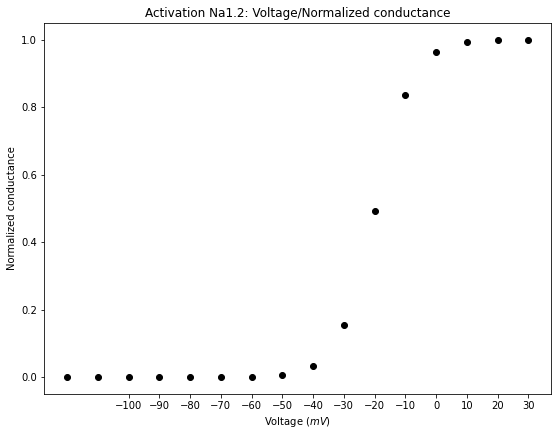

[Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6],
 Vector[6]]

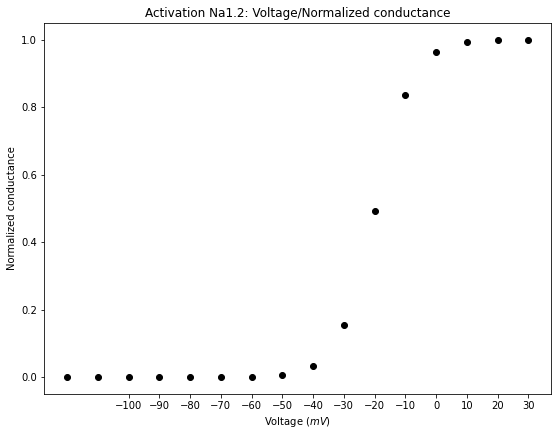

[Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59],
 Vector[59]]

(Vector[161],
 array([-120, -110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,
         -10,    0,   10,   20,   30]),
 [[3.0826776271615855e-12,
   -1.8387802872773553e-12,
   2.160458477586803e-12,
   2.303142130797623e-12,
   -4.1212669199800167e-14,
   2.4693682964149704e-12,
   -1.0530837882035306e-12,
   -9.095654159710186e-13,
   -9.045920017817345e-13,
   -9.040236165611602e-13,
   -9.04023616561183e-13,
   -9.040236165611959e-13,
   -9.040236165612032e-13,
   -9.040236165612074e-13,
   -9.040236165612097e-13,
   -9.040236165612111e-13,
   -9.040236165612118e-13,
   -9.040236165612122e-13,
   -9.040236165612125e-13,
   -9.040236165612126e-13,
   -9.040236165612127e-13,
   -9.040236165612127e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.04

<TopLevelHocInterpreter>

In [2]:
#### Examples ###

display(activationNa12("plotActivation"));

display(activationNa12("plotActivation", \
                  soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                  channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                  dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                  f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120, \
                  x_axis_min=-100, x_axis_max=40, x_axis_step=10));

display(activationNa12("genActivation"));


display(activationNa12("geth"));



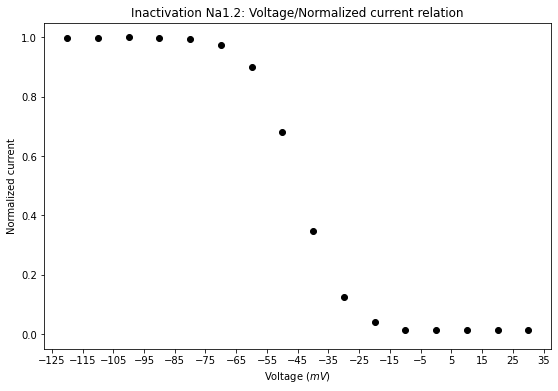

None

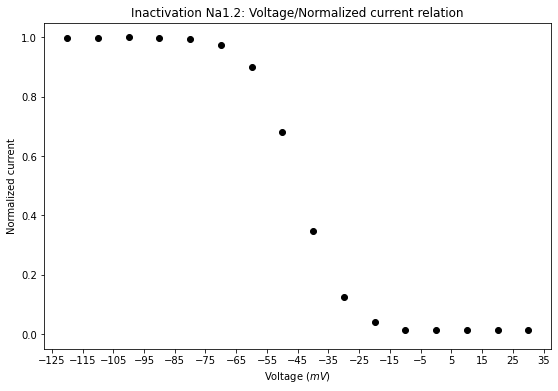

None

(Vector[186],
 array([-120, -110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,
         -10,    0,   10,   20,   30]),
 [[3.0826776271615855e-12,
   -1.8387802872773553e-12,
   2.160458477586803e-12,
   2.303142130797623e-12,
   -4.1212669199800167e-14,
   2.4693682964149704e-12,
   -1.0530837882035306e-12,
   -9.095654159710186e-13,
   -9.045920017817345e-13,
   -9.040236165611602e-13,
   -9.04023616561183e-13,
   -9.040236165611959e-13,
   -9.040236165612032e-13,
   -9.040236165612074e-13,
   -9.040236165612097e-13,
   -9.040236165612111e-13,
   -9.040236165612118e-13,
   -9.040236165612122e-13,
   -9.040236165612125e-13,
   -9.040236165612126e-13,
   -9.040236165612127e-13,
   -9.040236165612127e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.04

(Vector[192],
 array([-120, -110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,
         -10,    0,   10,   20,   30]),
 [[3.0826776271615855e-12,
   -1.8387802872773553e-12,
   2.160458477586803e-12,
   2.303142130797623e-12,
   -4.1212669199800167e-14,
   2.4693682964149704e-12,
   -1.0530837882035306e-12,
   -9.095654159710186e-13,
   -9.045920017817345e-13,
   -9.040236165611602e-13,
   -9.04023616561183e-13,
   -9.040236165611959e-13,
   -9.040236165612032e-13,
   -9.040236165612074e-13,
   -9.040236165612097e-13,
   -9.040236165612111e-13,
   -9.040236165612118e-13,
   -9.040236165612122e-13,
   -9.040236165612125e-13,
   -9.040236165612126e-13,
   -9.040236165612127e-13,
   -9.040236165612127e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.040236165612128e-13,
   -9.04

In [3]:
#### Examples ###

display(inactivationNa12("plotInactivation"))

display(inactivationNa12("plotInactivation", \
                    soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                    channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                    dur=500, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                    f3cl_dur0=40, f3cl_amp0=-120, f3cl_dur2=20, f3cl_amp2=-10, \
                    x_axis_min=-125, x_axis_max=40, x_axis_step=10));


display(inactivationNa12("genInactivation"))

display(inactivationNa12("genInactivation", \
                    soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                    channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                    dur=500, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                    f3cl_dur0=40, f3cl_amp0=-120, f3cl_dur2=20, f3cl_amp2=-10, \
                    x_axis_min=-125, x_axis_max=40, x_axis_step=10));



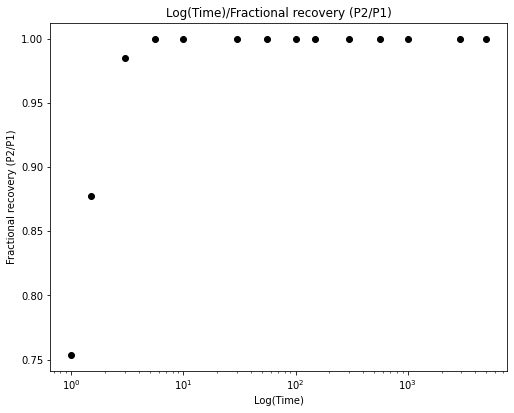

None

Vector[206]

([0.7534033471926392,
  0.8775135159739441,
  0.9849896075655309,
  0.9996054342692015,
  0.9999991647520349,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448],
 [1, 1.5, 3, 5.6, 10, 30, 56, 100, 150, 300, 560, 1000, 2930, 5000])

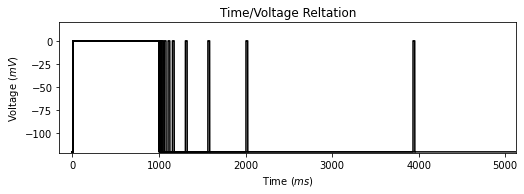

None

([0.7534033471926392,
  0.8775135159739441,
  0.9849896075655309,
  0.9996054342692015,
  0.9999991647520349,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448],
 [1, 1.5, 3, 5.6, 10, 30, 56, 100, 150, 300, 560, 1000, 2930, 5000])

([0.7534033471926392,
  0.8775135159739441,
  0.9849896075655309,
  0.9996054342692015,
  0.9999991647520349,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448],
 [1, 1.5, 3, 5.6, 10, 30, 56, 100, 150, 300, 560, 1000, 2930, 5000])

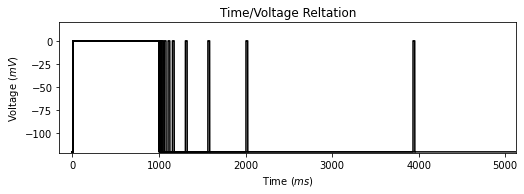

None

([0.7534033471926392,
  0.8775135159739441,
  0.9849896075655309,
  0.9996054342692015,
  0.9999991647520349,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448,
  0.9999999999930448],
 [1, 1.5, 3, 5.6, 10, 30, 56, 100, 150, 300, 560, 1000, 2930, 5000])

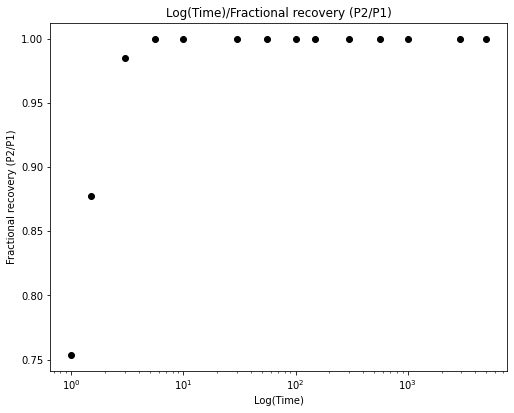

None

Vector[262]

In [4]:
#### Examples ###

display(recInactTauNa12("plotRecInact", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120));

display(recInactTauNa12("genRecInactTau", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))

display(recInactTauNa12("genRecInactTauCurve", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))


display(recInactTauNa12("plotRecInactProcedure", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120));


display(recInactTauNa12("genRecInact", ntrials=30, recordTime=500, \
                      soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                       channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                        min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                        vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                        f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))



display(recInactTauNa12("genRecInact"));

display(recInactTauNa12("plotRecInactProcedure"));

display(recInactTauNa12("genRecInactTauCurve"));

display(recInactTauNa12("plotRecInact"));

display(recInactTauNa12("genRecInactTau"));

In [5]:
#### Examples ###

display(recInact_dv_TauNa12("genRecInactTaudv"));

display(recInact_dv_TauNa12("genRecInactTauCurvedv"));

display(recInact_dv_TauNa12("genRecInact"));

display(recInact_dv_TauNa12("genRecInactTaudv", \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.01,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1, res_pot=-120, dur=0.1,\
                   vec_pts = np.linspace(-120,0,num=13),\
                   f3cl_dur0=50, f3cl_amp0=-120, f3cl_dur1=5, f3cl_amp1=0, f3cl_dur2=1, \
                   f3cl_dur3=5, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))

display(recInact_dv_TauNa12("genRecInactTauCurvedv", \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.01,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1, res_pot=-120, dur=0.1,\
                   vec_pts = np.linspace(-120,0,num=13),\
                   f3cl_dur0=50, f3cl_amp0=-120, f3cl_dur1=5, f3cl_amp1=0, f3cl_dur2=1, \
                   f3cl_dur3=5, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))

display(recInact_dv_TauNa12("genRecInact", \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.01,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1, res_pot=-120, dur=0.1,\
                   vec_pts = np.linspace(-120,0,num=13),\
                   f3cl_dur0=50, f3cl_amp0=-120, f3cl_dur1=5, f3cl_amp1=0, f3cl_dur2=1, \
                   f3cl_dur3=5, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120))

c:\users\ccfla\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:938: RuntimeWarning: divide by zero encountered in log


(Vector[269],
 [[6.110501373553928e-12,
   -5.596377378983171e-13,
   6.417308588804103e-13,
   3.5000128560979886e-12,
   -2.7463327038067203e-12,
   2.7529399540253866e-12,
   -1.6058068985442536e-12,
   2.1039413500842755e-12,
   -2.5773576546424146e-13,
   2.0516552905561087e-13,
   2.4437998375399835e-13,
   2.5006327296548074e-13,
   2.5006327296512925e-13,
   2.5006327296484905e-13,
   2.500632729646257e-13,
   2.5006327296444767e-13,
   2.5006327296430575e-13,
   2.500632729641926e-13,
   2.5006327296410244e-13,
   2.500632729640306e-13,
   2.500632729639733e-13,
   2.500632729639276e-13,
   2.500632729638912e-13,
   2.5006327296386223e-13,
   2.500632729638391e-13,
   2.500632729638206e-13,
   2.5006327296380593e-13,
   2.500632729637942e-13,
   2.500632729637849e-13,
   2.5006327296377746e-13,
   2.5006327296377155e-13,
   2.500632729637668e-13,
   2.50063272963763e-13,
   2.5006327296376004e-13,
   2.500632729637576e-13,
   2.5006327296375575e-13,
   2.500632729637542e-13,
 

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 array([-120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.]))

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 array([-120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.]))

(Vector[290],
 [[6.110501373553928e-12,
   -5.596377378983171e-13,
   6.417308588804103e-13,
   3.5000128560979886e-12,
   -2.7463327038067203e-12,
   2.7529399540253866e-12,
   -1.6058068985442536e-12,
   2.1039413500842755e-12,
   -2.5773576546424146e-13,
   2.0516552905561087e-13,
   2.4437998375399835e-13,
   2.5006327296548074e-13,
   2.5006327296512925e-13,
   2.5006327296484905e-13,
   2.500632729646257e-13,
   2.5006327296444767e-13,
   2.5006327296430575e-13,
   2.500632729641926e-13,
   2.5006327296410244e-13,
   2.500632729640306e-13,
   2.500632729639733e-13,
   2.500632729639276e-13,
   2.500632729638912e-13,
   2.5006327296386223e-13,
   2.500632729638391e-13,
   2.500632729638206e-13,
   2.5006327296380593e-13,
   2.500632729637942e-13,
   2.500632729637849e-13,
   2.5006327296377746e-13,
   2.5006327296377155e-13,
   2.500632729637668e-13,
   2.50063272963763e-13,
   2.5006327296376004e-13,
   2.500632729637576e-13,
   2.5006327296375575e-13,
   2.500632729637542e-13,
 

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 array([-120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.]))

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 array([-120., -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,
         -30.,  -20.,  -10.,    0.]))

In [6]:
#####################################################################################################################

In [12]:
### Visualization Purposes ###

from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import optimize, stats
h.dt = 0.025
##################
# Activation Na 1.2 
##################e
 
# Args: String command

# default args:
# str channel_name : name of channel to insert, default 
# x_axis_min : lower bound for x-axis
# x_axis_max : upper bound for x_axis
# x_axis_step : xticks

# one compartment cell
# soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
# channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025

# clamping params
# dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120

# a electrode voltage clamp ## not all nums included
# f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120

# for plotting
# x_axis_min=-100, x_axis_max=40, x_axis_step=10

def activationNa12_plots (command, \
                  soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                  channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                  dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                  f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120, \
                  x_axis_min=-100, x_axis_max=40, x_axis_step=10):
 
    dtype = np.float64
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
     
    soma.diam   = soma_diam        # micron
    soma.L      = soma_L  # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg         # adimensional
    soma.cm     = soma_cm         # uF/cm2
    soma.Ra     = soma_Ra       # ohm-cm
 
    soma.insert(channel_name)     #insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius        # temperature in celsius
    v_init      = v_init      # holding potential
    h.dt        = h_dt      # ms - value of the fundamental integration time step, dt, used by fadvance().
 
    # clamping parameters
    dur         = dur       # clamp duration, ms
    step        = step         # voltage clamp increment, the user can 
    st_cl       = st_cl       # clamp start, mV 
    end_cl      = end_cl        # clamp end, mV
    v_cl        = v_cl       # actual voltage clamp, mV 
 
    # a electrode voltage clamp
    f3cl = h.VClamp(soma(0.5))
    f3cl.dur[0] = f3cl_dur0      # ms 
    f3cl.amp[0] = f3cl_amp0    # mV 
    f3cl.dur[1] = dur     # ms
    f3cl.amp[1] = v_cl    # mV
    f3cl.dur[2] = f3cl_dur2      # ms 
    f3cl.amp[2] = f3cl_amp2    # mV 
 
    #number of elements of the vector containing the values from st_cl to end_cl with the fixed step
    L=len(np.arange(st_cl, end_cl, step))
 
    # vectors for data handling
    t_vec       = h.Vector()  # vector for time
    v_vec       = h.Vector()  # vector for voltage
    v_vec_t     = h.Vector()  # vector for voltage as function of time
    i_vec       = h.Vector()  # vector for current 
    ipeak_vec   = h.Vector()  # vector for peak current
    gpeak_vec   = h.Vector()  # vector for peak conductance
    gnorm_vec   = h.Vector()  # vector for normalized conductance
    all_is = []
 
    # clamping definition
    def clamp(v_cl):
        """
        Advances voltage clamp and updates data handling vectors.
        clamping definition.
        
        Args:
            v_cl (int): current voltage at which to run
        """
        curr_tr = 0  # initialization of peak current
 
        h.finitialize(v_init) # calling the INITIAL block of the mechanism inserted in the section.
 
        # initialization of variables used to commute the peak current and conductance    
        pre_i  = 0    
        dens   = 0
 
        f3cl.amp[1] = v_cl    # mV
 
        for j in range(30):
 
            while (h.t<h.tstop): # runs a single trace, calculates peak current
                dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
 
                t_vec.append(h.t)       # code for storing the current
                v_vec_t.append(soma.v)  # trace to be plotted
                i_vec.append(dens)      # trace to be plotted
 
                if ((h.t>5)and(h.t<=10)):       # evaluate the peak 
                    if(abs(dens)>abs(pre_i)):
                        curr_tr = dens          # updates the peak current
 
                h.fadvance()
                pre_i = dens
        
        # updates the vectors at the end of the run        
        v_vec.append(v_cl)              
        ipeak_vec.append(curr_tr)

    def findG(v_vec, ipeak_vec):
        """
        Finds normalized conductance from the IV curve fitted to a boltzmann.
        
        Args:
            i_vec (vector): vector of currents
            v_vec (vector): vector of voltages
        
        Returns:
            norm_g (vector): normalized conductance
        """
        inds = 0                                      #initialize index
        inds = v_vec.indwhere("==", 0)                #find start of linear portion
                
        #take linear portion of voltage and current relationship
        lin_v = v_vec.at(inds)
        lin_i = ipeak_vec.at(inds)
        
        vrev = stats.linregress(lin_i, lin_v).intercept
                
        def boltzmann(vm, Gmax, v_half, s):
            return Gmax * (vm - vrev) / (1 + np.exp((v_half - vm) / s))
        
        Gmax, v_half, s = optimize.curve_fit(boltzmann, v_vec, ipeak_vec)[0]
        
        #find conductances at each voltage
        norm_g = h.Vector()
        
        for volt in v_vec:
            norm_g.append(1/ (1 + np.exp(-(volt - v_half) / s)))
            
        return norm_g
 
    ### start program and plots
    def plotAllActivation():
 
        # figure definition
        fig, ax     = plt.subplots(1, 3,figsize=(18,6))  
        fig.suptitle('Activation: Voltage-Normalized conductance relation', fontsize=15, fontweight='bold')
        fig.subplots_adjust(wspace=0.5)

        ax[0].set_xlabel('Time $(ms)$')
        ax[0].set_ylabel('Voltage $(mV)$')
        ax[0].set_title('Time/Voltage relation')

        ax[1].set_xlabel('Time $(ms)$')
        ax[1].set_ylabel('Current density $(mA/cm^2)$')
        ax[1].set_title('Time/Current density relation')
       
        ax[2].set_xlabel('Voltage $(mV)$')
        ax[2].set_ylabel('Normalized conductance')
        ax[2].set_title('Voltage/Normalized conductance')

        # to plot in rainbow colors
        values      = range(L)
        rbw         = cm = plt.get_cmap('rainbow') 
        cNorm       = colors.Normalize(vmin=0, vmax=values[-1])
        scalarMap   = cmx.ScalarMappable(norm=cNorm, cmap=rbw)
        
        h.tstop = 5 + dur + 5       # time stop
 
        # resizing the vectors
        v_vec.resize(0)          
        gpeak_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter for plotting rainbow colors
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
                # resizing the vectors
                t_vec.resize(0)  
                i_vec.resize(0) 
                v_vec_t.resize(0) 
 
                clamp(v_cl)
                all_is.append(i_vec)
            
                # code for plotting traces
                colorVal1 = scalarMap.to_rgba(v_cl-st_cl-k*(step-1)) # rainbow printing setting
                k=k+1
                ln0,=ax[0].plot(t_vec, v_vec_t,color=colorVal1)
                n1,=ax[1].plot(t_vec, i_vec,color=colorVal1)
 
        gnorm_vec = findG(v_vec, ipeak_vec)
        for i in range(0, len(gnorm_vec), 1):
             # plot 
             colorVal2 = scalarMap.to_rgba(i) # rainbow printing setting
             ln2, =ax[2].plot(v_vec.x[i], gnorm_vec.x[i], 'o', c=colorVal2)
 
        plt.show()
 

    #Command Processor
    if command == "plotAllActivation":
        return plotAllActivation()
    else:
        print("Invalid command. Function does not exist.")
 
##################
# Inactivation Na 1.2 
##################
 
# Args: String command

# default args:
# str channel_name : name of channel to insert, default 
# x_axis_min : lower bound for x-axis
# x_axis_max : upper bound for x_axis
# x_axis_step : xticks

# one compartment cell
# soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
# channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025

# clamping params
# dur=10, step=10, st_cl=-120, end_cl=40, v_cl=-120

# a electrode voltage clamp ## not all nums included
# f3cl_dur0=5, f3cl_amp0=-120, f3cl_dur2=5, f3cl_amp2=-120

# for plotting
# x_axis_min=-100, x_axis_max=40, x_axis_step=10
def inactivationNa12_plots(command, \
                    soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                    channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.025, \
                    dur=500, step=10, st_cl=-120, end_cl=40, v_cl=-120, \
                    f3cl_dur0=40, f3cl_amp0=-120, f3cl_dur2=20, f3cl_amp2=-10, \
                    x_axis_min=-125, x_axis_max=40, x_axis_step=10):
    dtype = np.float64
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
    soma.diam   = soma_diam         # micron
    soma.L      = soma_L   # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg          # adimensional
    soma.cm     = soma_cm          # uF/cm2
    soma.Ra     = soma_Ra         # ohm-cm
 
    soma.insert(channel_name)      # insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius         # temperature in celsius
    v_init      = v_init       # holding potential   
    h.dt        = h_dt       # ms - value of the fundamental integration time step, dt, used by fadvance().
 
    # clamping parameters
    dur         = dur     # clamp duration, ms
    step        = step          # voltage clamp increment
    st_cl       = st_cl       # clamp start, mV
    end_cl      = end_cl          # clamp end, mV
    v_cl        = v_cl       # actual voltage clamp, mV
 
    #number of elements of the vector containing the values from st_cl to end_cl with the fixed step
    L=len(np.arange(st_cl, end_cl, step))
 
    # vectors for data handling
    t_vec       = h.Vector() # vector for time
    v_vec       = h.Vector() # vector for voltage
    v_vec_t     = h.Vector() # vector for voltage as function of time
    i_vec       = h.Vector() # vector for current 
    ipeak_vec   = h.Vector() # vector for peak current
    inorm_vec   = h.Vector() # vector for normalized current
    
    # a electrode voltage clamp
    f3cl = h.VClamp(soma(0.5))
    f3cl.dur[0] = f3cl_dur0         # ms
    f3cl.amp[0] = f3cl_amp0       # mV
    f3cl.dur[1] = dur        # ms
    f3cl.amp[1] = v_cl       # mV
    f3cl.dur[2] = f3cl_dur2         # ms
    f3cl.amp[2] = f3cl_amp2        # mV
    all_is=[]
    
    # clamping definition
    def clamp(v_cl):
 
        f3cl.amp[1] = v_cl
        h.finitialize(v_init)  # calling the INITIAL block of the mechanism inserted in the section.
 
        # parameters initialization
        peak_curr = 0
        dens = 0
        t_peak = 0
        dtsave = h.dt
       
        for j in range(30):
            
            while (h.t<h.tstop): # runs a single trace, calculates peak current
                if (h.t >537) or (h.t<40):
                    h.dt = dtsave
                else:
                    h.dt =1
                dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
                t_vec.append(h.t)       # code for store the current
                v_vec_t.append(soma.v)  # trace to be plotted
                i_vec.append(dens)      # trace to be plotted
                
                if ((h.t>=540)and(h.t<=542)):     # evaluate the peak (I know it is there)
                    if(abs(dens)>abs(peak_curr)):
                        peak_curr = dens        
                        t_peak = h.t
 
                h.fadvance()

            # updates the vectors at the end of the run        
        
        v_vec.append(v_cl)             
        ipeak_vec.append(peak_curr)
        
        
     ### start program and plots
    def plotAllInactivation():
 
        # figure definition
        fig, ax     = plt.subplots(1, 3,figsize=(18,6))  
        fig.suptitle('Inactivation: Voltage-Normalized conductance relation', fontsize=15, fontweight='bold')
        fig.subplots_adjust(wspace=0.5)

        ax[0].set_xlabel('Time $(ms)$')
        ax[0].set_ylabel('Voltage $(mV)$')
        ax[0].set_title('Time/Voltage relation')

        ax[1].set_xlabel('Time $(ms)$')
        ax[1].set_ylabel('Current density $(mA/cm^2)$')
        ax[1].set_title('Time/Current density relation')
       
        ax[2].set_xlabel('Voltage $(mV)$')
        ax[2].set_ylabel('Normalized conductance')
        ax[2].set_title('Voltage/Normalized conductance')

        # to plot in rainbow colors
        values      = range(L)
        rbw         = cm = plt.get_cmap('rainbow') 
        cNorm       = colors.Normalize(vmin=0, vmax=values[-1])
        scalarMap   = cmx.ScalarMappable(norm=cNorm, cmap=rbw)

        # add time padding 
        h.tstop = 40 + dur + 20
        v_vec.resize(0)
        ipeak_vec.resize(0)
 
        k=0     # counter for plotting rainbow colors
        for v_cl in np.arange(st_cl, end_cl, step): # iterates across voltages
 
 
            # resizing the vectors
            t_vec.resize(0)
            i_vec.resize(0)
            v_vec_t.resize(0) 
 
            # advance
            clamp(v_cl)
           
            # code for plotting traces
            colorVal1 = scalarMap.to_rgba(v_cl-st_cl-k*(step-1)) # rainbow printing setting
            k=k+1
            ln0,=ax[0].plot(t_vec, v_vec_t,color=colorVal1)
            n1,=ax[1].plot(t_vec, i_vec,color=colorVal1)
            
        ipeak_min = ipeak_vec.min()  # normalization of peak current with respect to the min since the values are negative
 
        for i in range(0, len(ipeak_vec), 1):
            inorm_vec.append(ipeak_vec.x[i]/ipeak_min)
            
            # plot 
            colorVal2 = scalarMap.to_rgba(i) # rainbow printing setting
            ln2,=ax[2].plot(v_vec.x[i], inorm_vec.x[i], 'o', c=colorVal2)
 
        plt.show()

 
    #Command Processor
    if command == "plotAllInactivation":
        return plotAllInactivation()
    else:
        print("Invalid command. Function does not exist.")
 
##################
# Recovery from Inactivation (RFI) &  RFI Tau Na 1.2 
##################
 
# Args: String command

# default args:
# ntrials : number of trials ntrials=30
# recordTime=500
# str channel_name : name of channel to insert, default 

# one compartment cell
# soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, 
# channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1

# clamping params for recInactTau
# min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1
# vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000]

# a voltage clamp with "five" levels for RecInactTau ## not all nums included
# f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120 

def recInactTauNa12_plots(command, \
                   ntrials=30, recordTime=500, \
                   soma_diam=50, soma_L=63.66198, soma_nseg=1, soma_cm=1, soma_Ra=70, \
                   channel_name='na12mut', soma_ena=55, h_celsius=33, v_init=-120, h_dt=0.1,\
                   min_inter=0.1, max_inter=5000, num_pts=50, cond_st_dur=1000, res_pot=-120, dur=0.1,\
                   vec_pts = [1,1.5,3,5.6,10,30,56,100,150,300,560,1000,2930,5000],\
                   f3cl_dur0=5, f3cl_amp0=-120, f3cl_amp1=0, f3cl_dur3=20, f3cl_amp3=0, f3cl_dur4=5, f3cl_amp4=-120):
    
    dtype = np.float64
 
    ntrials = ntrials
    recordTime = recordTime
 
    # one-compartment cell (soma)
    soma        = h.Section(name='soma2')
    soma.diam   = soma_diam        # micron
    soma.L      = soma_L  # micron, so that area = 10000 micron2
    soma.nseg   = soma_nseg         # dimensionless
    soma.cm     = soma_cm         # uF/cm2
    soma.Ra     = soma_Ra       # ohm-cm    
 
    soma.insert(channel_name)     #insert mechanism
    soma.ena    = soma_ena
    h.celsius   = h_celsius        # temperature in celsius
    v_init      = v_init      # holding potential
    h.dt        = h_dt       # ms - value of the fundamental integration time step, dt,
                                #used by fadvance() in RecInactTau. 
                                #Increase value to speed up recInactTau().
 
    # clamping parameters for RecInactTau
    min_inter    = min_inter      # pre-stimulus starting interval
    max_inter    = max_inter     # pre-stimulus endinging interval
    num_pts      = num_pts       # number of points in logaritmic scale
    cond_st_dur  = cond_st_dur     # conditioning stimulus duration
    res_pot      = res_pot     # resting potential
    dur          = dur
 
    # vector containing time points based on SCN2A ppt slide 3 for RecInactTau
    vec_pts = vec_pts
    L = len(vec_pts)
 
    # vectors for data handling RecInactTau
    rec_vec      = h.Vector()   
    time_vec     = h.Vector()   
    log_time_vec = h.Vector()   
    t_vec        = h.Vector()
    v_vec_t      = h.Vector()
    i_vec_t      = h.Vector()
    rec_inact_tau_vec = h.Vector()
 
    # voltage clamp with "five" levels for RecInactTau
    f3cl = h.VClamp_plus(soma(0.5))
    f3cl.dur[0] = f3cl_dur0              # ms
    f3cl.amp[0] = f3cl_amp0           # mV
    f3cl.dur[1] = cond_st_dur    # ms default 1000
    f3cl.amp[1] = f3cl_amp1          # mV
    f3cl.dur[2] = dur            # ms
    f3cl.amp[2] = res_pot        # mV default -120
    f3cl.dur[3] = f3cl_dur3             # ms
    f3cl.amp[3] = f3cl_amp3          # mV
    f3cl.dur[4] = f3cl_dur4              # ms
    f3cl.amp[4] = f3cl_amp4           # mV
 
 
    # clamping definition for RecInactTau
    def clampRecInactTau(dur): 
 
        f3cl.dur[2] = dur 
        # SCN2A ppt slide 3 -- time/voltage relation + 5 ms twice for padding
        h.tstop = 5 + 1000 + dur + 20 + 5
        h.finitialize(v_init)
 
        #variables initialization
        pre_i1 = 0
        pre_i2 = 0
        dens   = 0   
 
        peak_curr1 = 0    
        peak_curr2 = 0
 
 
        while (h.t<h.tstop): # runs a single trace, calculates peak current
 
            dens = f3cl.i/soma(0.5).area()*100.0-soma(0.5).i_cap # clamping current in mA/cm2, for each dt
            t_vec.append(h.t)      
            v_vec_t.append(soma.v) 
            i_vec_t.append(dens)
 
 
            if ((h.t>5)and(h.t<15)):       # evaluate the first peak
                if(pre_i1<abs(dens)):
                    peak_curr1=abs(dens)
                pre_i1=abs(dens)
 
 
            if ((h.t>(5+cond_st_dur+dur))and(h.t<(15+cond_st_dur+dur))):  # evaluate the second peak 
 
 
                if(pre_i2<abs(dens)):
                    peak_curr2=abs(dens)
                pre_i2=abs(dens)
 
            h.fadvance()
 
        # updates the vectors at the end of the run  
        time_vec.append(dur)
        log_time_vec.append(np.log10(dur))
        rec_vec.append(peak_curr2/peak_curr1)
 
        # calc RFI tau using RF and tstop
        ### reference DOI: https://doi.org/10.1038/s41598-019-53662-9 
            # equation (4): RF(t) = 1 - e^(-t/tau) ### 
        RF_t = peak_curr2/peak_curr1
        tau = -h.tstop / np.log(-RF_t + 1)
        #append values to vector
        rec_inact_tau_vec.append(tau)
 
    # start RecInact program and plot
    def plotAllRecInact():

        # figure definition
        fig, ax = plt.subplots(2, 2,figsize=(18,6))  
        ln0, = ax[0,0].plot([], [], '-')
        ln1, = ax[0,1].plot([], [], '-')
        ln2, = ax[1,0].plot([], [], '-')
        ln3, = ax[1,1].plot([], [], '-')
        fig.suptitle('Recovery from Inactivation and RFI Tau', fontsize=15, fontweight='bold')

        fig.subplots_adjust(wspace=0.5)
        fig.subplots_adjust(hspace=0.5)

        ax[0,0].set_xlabel('Time $(ms)$')
        ax[0,0].set_ylabel('Voltage $(mV)$')
        ax[0,0].set_title('Time/Voltage relation')

        ax[0,1].set_xlim(-50, 5 + max_inter)
        ax[0,1].set_ylim(-1.75,0.2)
        ax[0,1].set_xlabel('Time $(ms)$')
        ax[0,1].set_ylabel('Current density $(mA/cm^2)$')
        ax[0,1].set_title('Time/Current density relation')

        ax[1,0].set_xlabel('Time $(ms)$')
        ax[1,0].set_ylabel('Fractional recovery (P2/P1)')
        ax[1,0].set_title('Time/Fractional recovery (P2/P1)')

        ax[1,1].set_xlabel('Log(Time)')
        ax[1,1].set_ylabel('Fractional recovery (P2/P1)')
        ax[1,1].set_title('Log(Time)/Fractional recovery (P2/P1)')

        #to plot in rainbow colors
        values=range(L)
        rbw = cm = plt.get_cmap('rainbow') 
        cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rbw)
       
        k=0 #counter for plotting rainbow colors 
 
        for dur in vec_pts:
            # resizing the vectors
            t_vec.resize(0)
            i_vec_t.resize(0)
            v_vec_t.resize(0) 
            rec_vec.resize(0) 
            time_vec.resize(0)
            log_time_vec.resize(0)
            rec_inact_tau_vec.resize(0)
 
            # advance
            clampRecInactTau(dur) 
    
            # plot 
            colorVal1 = scalarMap.to_rgba(k)    
            k+=1
            ln0,=ax[0,0].plot(t_vec, v_vec_t, color=colorVal1)
            ln1,=ax[0,1].plot(t_vec, i_vec_t, color=colorVal1)
            ln2=ax[1,0].scatter(time_vec, rec_vec, color=colorVal1)
            ln3=ax[1,1].scatter(log_time_vec, rec_vec, color=colorVal1)
        
        plt.show()
        
     #Command Processor
    if command == "plotAllRecInact":
        return plotAllRecInact()
    else:
        print("Invalid command. Function does not exist.")


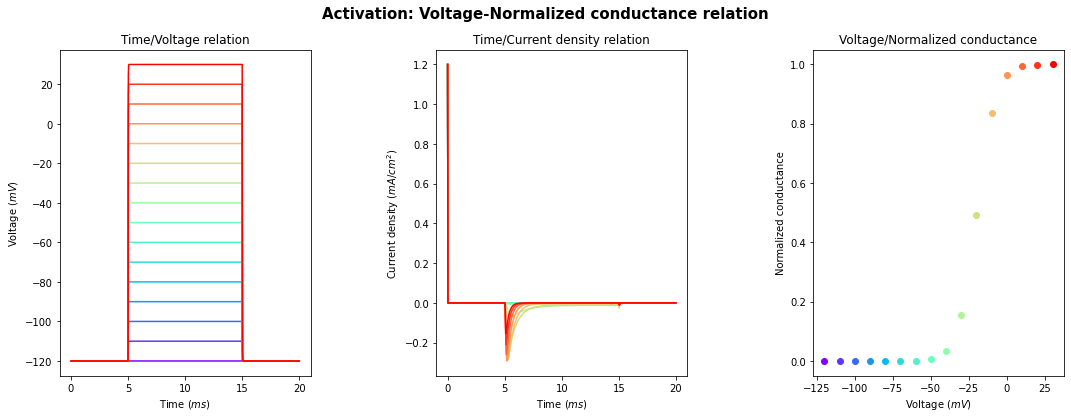

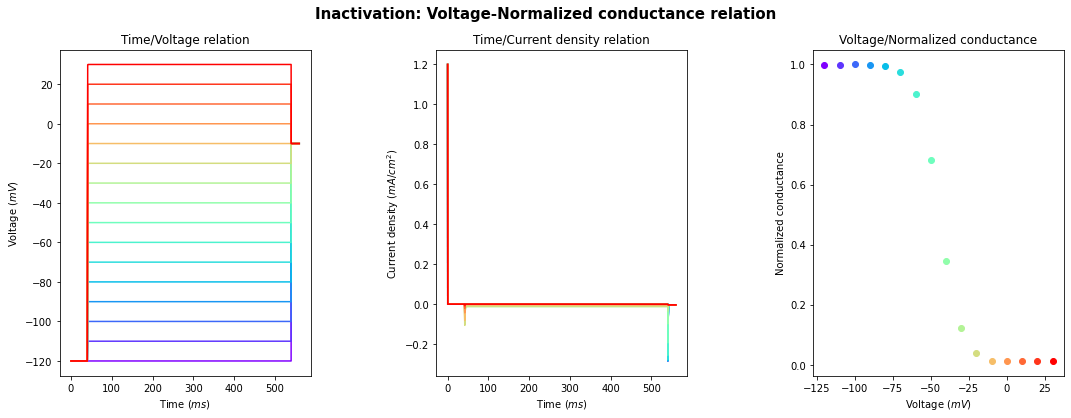

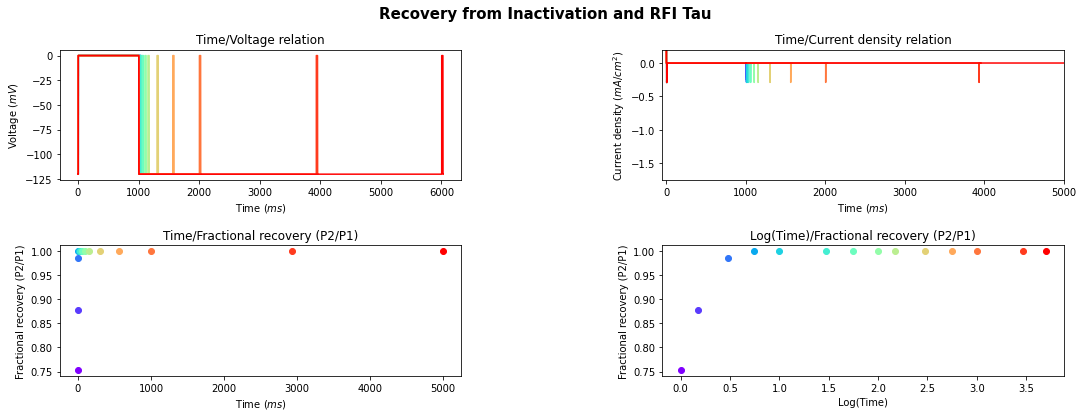

In [13]:
### More Plots ###
### For Visualization Purposes ###

%matplotlib qt
%matplotlib inline


activationNa12_plots("plotAllActivation")

inactivationNa12_plots("plotAllInactivation")

recInactTauNa12_plots("plotAllRecInact")



In [9]:
#####################################################################################################################